# ECE 417 Lecture 12: Image Upsampling and Downsampling
## Mark Hasegawa-Johnson, September 30, 2019
This file is distributed under a <a href="https://creativecommons.org/licenses/by/3.0/">CC-BY</a> license.  You may freely re-use or re-distribute the whole or any part.  If you re-distribute a non-trivial portion of it, give me credit.

## Outline of Today's lecture
* Downsampling
* Decimation
* Upsampling 
* Piece-wise constant interpolation
* Piece-wise linear interpolation
* Piece-wise spline interpolation
* Sinc interpolation

# Preliminaries
First let's load some libraries, and some data.

Text(0.5, 1.0, 'Image of a cat with resolution (240, 424, 3)')

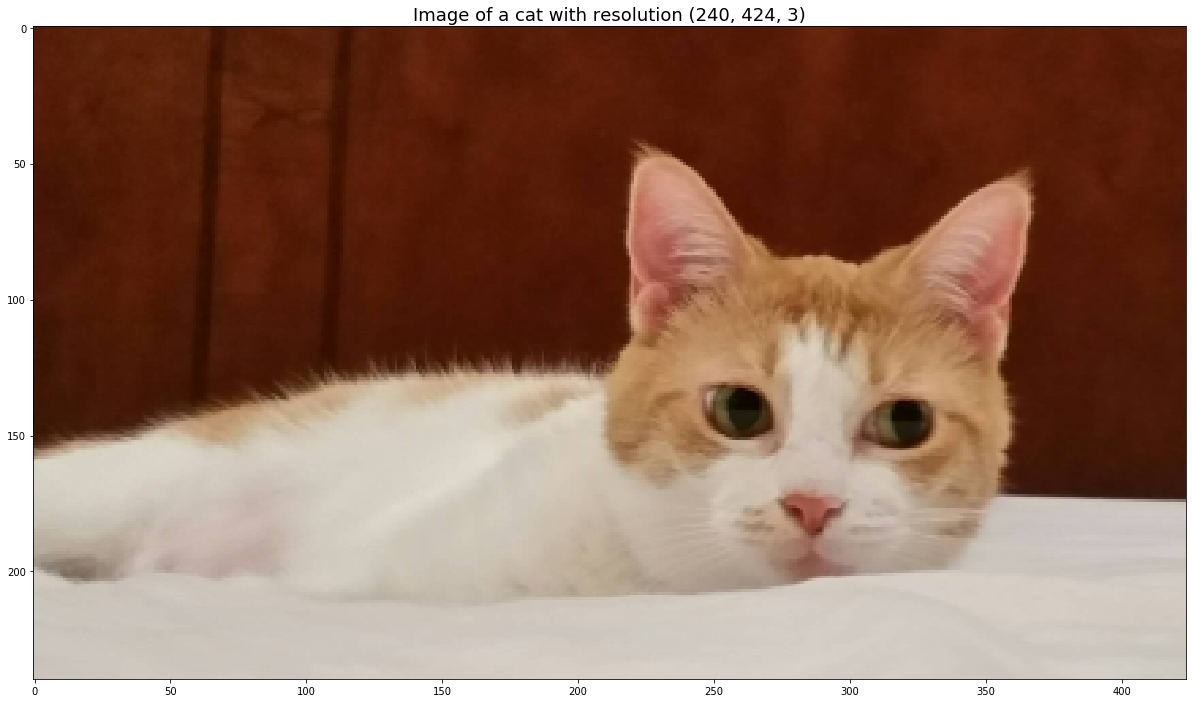

In [1]:
import scipy.fftpack as fft # FFT computations
import imageio # for image i/o
import numpy as np  # general numeric operations and matrices
import io # for io.BytesIO, turns the data stream into a file-like object
import matplotlib.pyplot as plt # allows us to plot things
import urllib.request as request # downloads a file from the web
import math # for things like pi
%matplotlib inline
image_url = 'http://courses.engr.illinois.edu/ece417/fa2018/cat400.png'
cat400=imageio.imread(io.BytesIO(request.urlopen(image_url).read()))
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat400)
plt.title('Image of a cat with resolution {}'.format(cat400.shape),fontsize=18)


# Downsampling

Downsampling just means we remove $D-1$ out of every $D$ samples, thus
$$y[m,n,k]=x[mD,nD,k]$$

I think you've seen this analyzed in ECE 310 for the case of one-D signals, where we have
$$y[n] = x[mD]$$

This is easiest to analyze in two steps.  First, multiply $x[n]$ by 
$$p[n]=\sum_{m=-\infty}^\infty \delta[n-mD]$$
which has a transform of 
$$P(\omega)=\frac{2\pi}{D}\sum_{k=0}^{D-1} \delta\left(\omega-\frac{2\pi k}{D}\right)$$
Multiplying in the time domain is convolving in the frequency domain:
$$v[n]=x[n]p[n] \leftrightarrow V(\omega)=\frac{1}{2\pi} X(\omega)\ast P(\omega) = \frac{1}{D}\sum_{d=0}^{D-1}X\left(\omega-\frac{2\pi k}{D}\right)$$
Which has aliasing!!

Then we downsample, to get
$$y[n] = v[nD]$$
$$Y(\omega)=\sum_n y[n]e^{-j\omega n}=\sum_m v[m=nD]e^{-j\omega m/D}=V\left(\frac{\omega}{D}\right)$$
$$Y(\omega) = \left(\frac{1}{D}\right)\sum_{d=0}^{D-1} X\left(\frac{\omega-2\pi d}{D}\right)$$

Text(0.5, 1.0, 'Cat Decimated to 60x106x3')

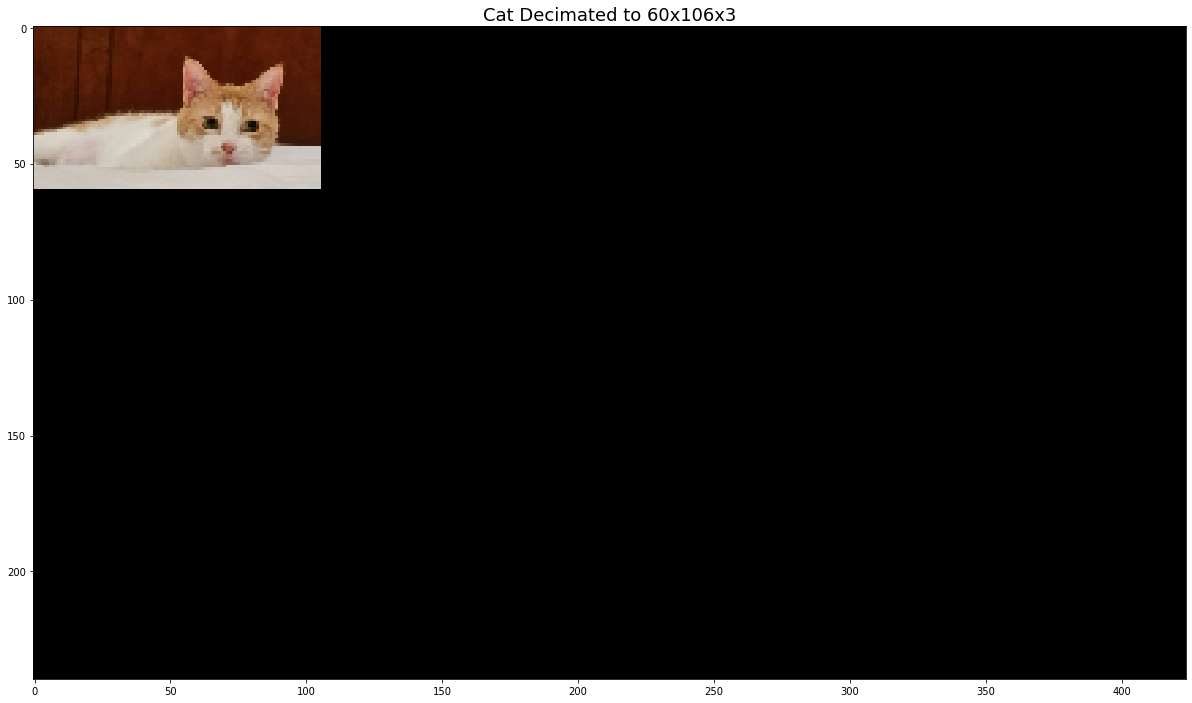

In [2]:
(M,N,K)=cat400.shape
cat100=np.zeros((M,N,K),dtype=cat400.dtype)
for m in range(0,int(M/4)):
    for n in range(0,int(N/4)):
        for k in range(0,K):
            cat100[m,n,k]=cat400[4*m,4*n,k]
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat100)
plt.title('Cat Decimated to 60x106x3',fontsize=18)

Text(0.5, 1.0, 'Row 160 of fullsize image, row 40 of decimated image, Blue plane')

<Figure size 432x288 with 0 Axes>

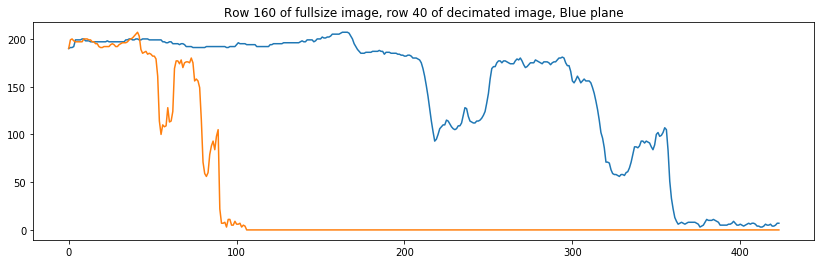

In [3]:
plt.figure()
t4=np.linspace(0,N-1,N,dtype='int16')
f1=plt.figure(figsize=(14,4))
plt.plot(t4,cat400[160,:,2],t4,cat100[40,:,2])
plt.title('Row 160 of fullsize image, row 40 of decimated image, Blue plane')



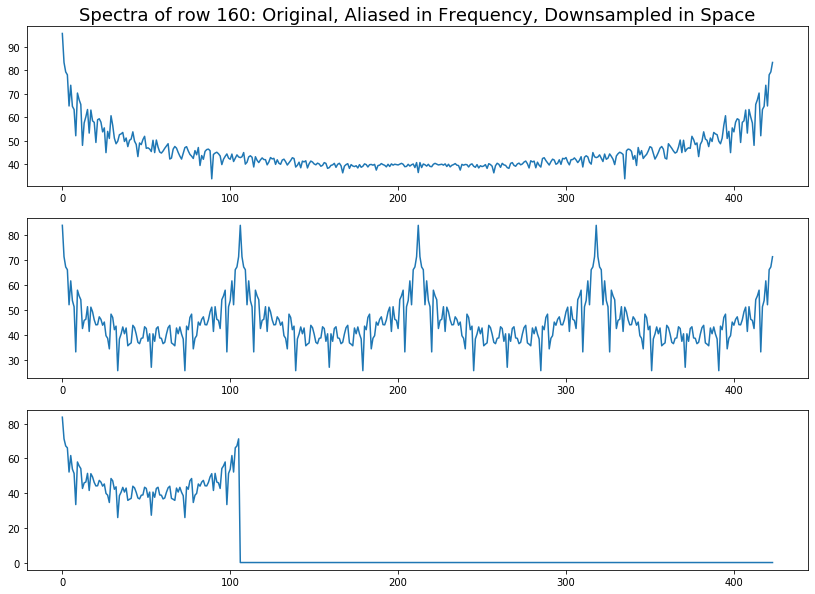

In [4]:
spec400=fft.fft(cat400[160,:,2])
aliased = np.zeros(spec400.shape)
for m in range(0,4):
    aliased = aliased + np.roll(spec400,m*106)
aliased = aliased / 4
spec100 = np.ones(spec400.shape,dtype=complex)
spec100[0:106]=fft.fftn(cat100[40,0:106,2])

plt.figure(1,figsize=(14,10))
plt.subplot(311)
plt.plot(20*np.log10(abs(spec400)))
plt.title('Spectra of row 160: Original, Aliased in Frequency, Downsampled in Space',fontsize=18)
plt.subplot(312)
plt.plot(20*np.log10(abs(aliased)))
plt.subplot(313)
plt.plot(20*np.log10(abs(spec100)))


# Decimation
We can avoid aliasing by lowpass filtering the signal prior to downsampling.

An ideal lowpass filter with cutoff frequency $\omega_c$ is given by
$$h[n]=\frac{\omega_c}{\pi}\mbox{sinc}(\omega_c n)=\frac{\sin(\omega_c n)}{\pi n}$$
When we create a lowpass filter by hand, we have to be careful with the $n=0$ sample:
$$h[0]=\frac{\omega_c}{\pi}$$
In order to avoid aliasing, we need
$$\omega_c=\frac{\pi}{D}$$
We can approximate an ideal lowpass filter by creating a reasonably long, rectangular-windowed FIR filter
(Hamming window would be better).  Then we can lowpass filter by convolving each row and each column:
    $$x_{lpf}[n]=h[n]\ast x[n]$$
    $$y_{lpf}[n] = x_{lpf}[nD]$$

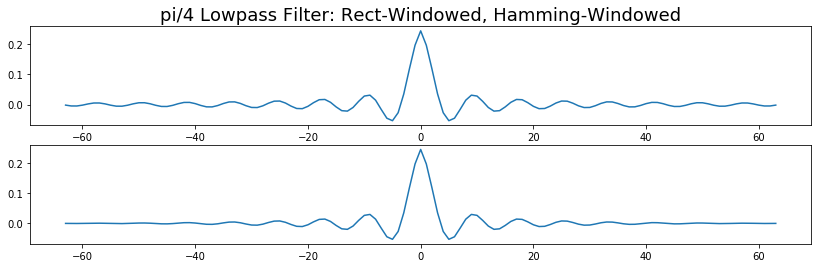

In [5]:
n_axis = np.linspace(-63.5,63.5,128,dtype='int16')
lpf_rect = np.zeros(128)
lpf = np.zeros(128)
zero_sample = 63.5
hamwin = np.zeros(128)
for n in range(0,64):
    lpf_rect[int(zero_sample+n+0.5)]=np.sin(0.25*np.pi*(n+0.5))/(np.pi*(n+0.5))
    lpf_rect[int(zero_sample-n-0.5)]=lpf_rect[int(zero_sample+n+0.5)]
    hamwin[int(zero_sample+n+0.5)]=0.54+0.46*math.cos(math.pi*(n+0.5)/64)
    hamwin[int(zero_sample-n-0.5)]=hamwin[int(zero_sample+n+0.5)]
    lpf[int(zero_sample+n+0.5)]=lpf_rect[int(zero_sample+n+0.5)]*hamwin[int(zero_sample+n+0.5)]
    lpf[int(zero_sample-n-0.5)]=lpf_rect[int(zero_sample-n-0.5)]*hamwin[int(zero_sample-n-0.5)]
plt.figure(1,figsize=(14,4))
plt.subplot(211)
plt.plot(n_axis,lpf_rect)
plt.title('pi/4 Lowpass Filter: Rect-Windowed, Hamming-Windowed',fontsize=18)
plt.subplot(212)
plt.plot(n_axis,lpf)


### Separable Filter

The np.convolve2d function implements convolution in two dimensions, but it's very slow to convolve in 2D (complexity is O($M^2N^2$)).  

A much faster method is to first convolve each column (complexity: O($N^2$)), then convolve each row (complexity: O($M^2$)), total complexity is only O($M^2+N^2$).  This is called "separable filtering".

Here, we use mode='nearest' in order to repeat the outermost edge outward as padding for the convolution.

Text(0.5, 1.0, 'Cat that has been convolved with an LPF')

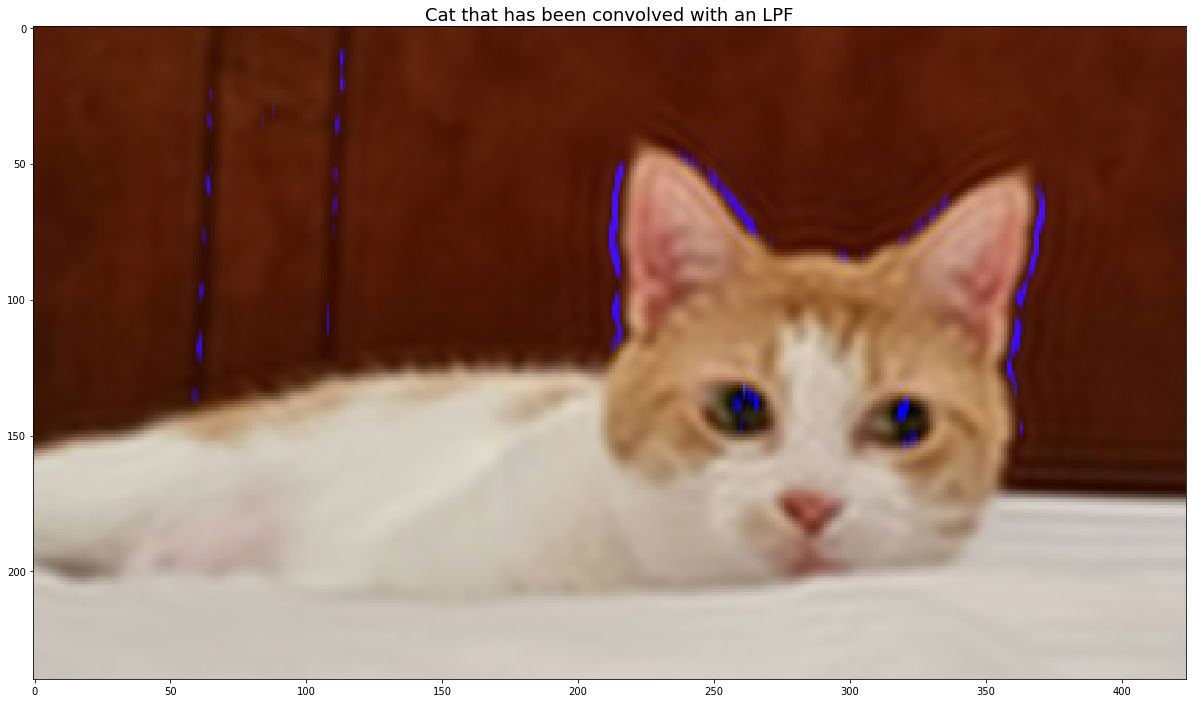

In [6]:
import scipy.ndimage.filters as filters
cat_half_filtered_double = np.zeros(cat400.shape)
cat_filtered_double = np.zeros(cat400.shape)
for k in range(0,K):
    for m in range(0,M):
        cat_half_filtered_double[m,:,k]=filters.convolve1d(cat400[m,:,k],lpf,mode='nearest')
    for n in range(0,N):
        cat_filtered_double[:,n,k]=filters.convolve1d(cat_half_filtered_double[:,n,k],lpf,mode='nearest')
cat_filtered = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_filtered_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_filtered)
plt.title('Cat that has been convolved with an LPF',fontsize=18)

## Decimation = Filtering followed by downsampling
Now let's dowsample the filtered image.  This should give a spectrum with much less downsample-aliasing.

Text(0.5, 1.0, 'Decimated cat: lowpass filtered, then downsampled')

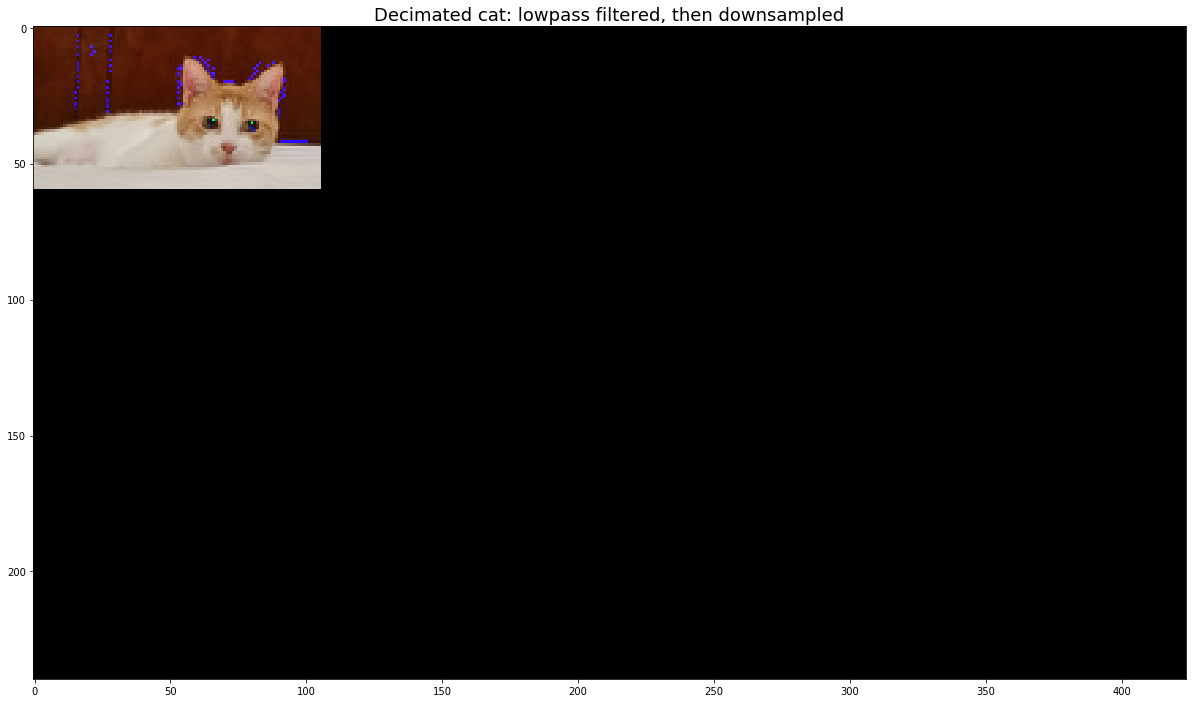

In [7]:
catf100_double = np.zeros(cat100.shape,dtype=cat400.dtype)
for m in range(0,int(M/4)):
    for n in range(0,int(N/4)):
        for k in range(0,K):
            catf100_double[m,n,k] = cat_filtered_double[4*m,4*n,k]
catf100 = np.ndarray.astype(np.maximum(0,np.minimum(255,catf100_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(catf100)
plt.title('Decimated cat: lowpass filtered, then downsampled',fontsize=18)

# Upsampling

Upsampling is the process of creating a larger image, from a smaller image, by just inserting zeros:
$$z[m,n,k] = \left\{\begin{array}{ll}
y[m/D,n/D,k] & m/D,~n/D~\mbox{are integers}\\
0 & \mbox{otherwise}
\end{array}\right.$$

Again, the problem is aliasing:
$$Z(\omega) = Y(D\omega)$$

This time, though, the aliasing is much more visible in the image.  In fact, the image is mostly black dots, with a few spots of color (one per $D\times D$ square).


Text(0.5, 1.0, 'Cat that has been upsampled without interpolation')

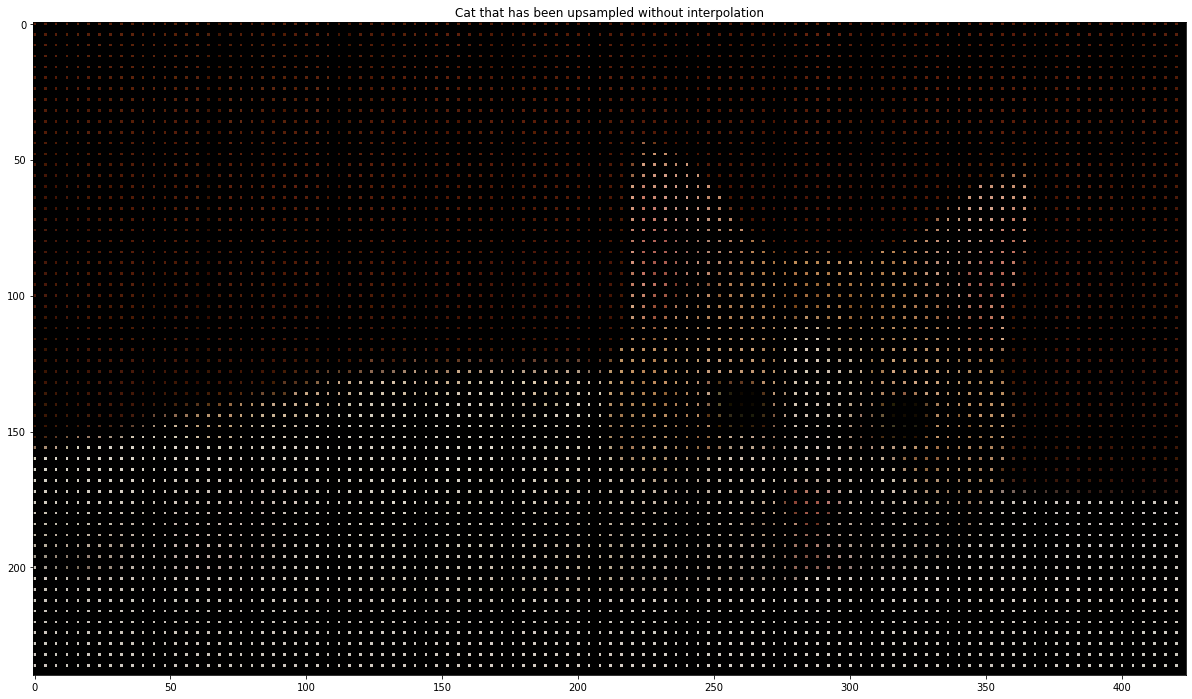

In [8]:
cat_upsampled_double = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,60):
    for n in range(0,106):
        for k in range(0,K):
            cat_upsampled_double[4*m,4*n,k]=cat100[m,n,k]
cat_upsampled = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_upsampled_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_upsampled)
plt.title('Cat that has been upsampled without interpolation')

#  Piece-wise constant interpolation

The solution is obvious: rather than just filling zeros between the upsampled samples, we need to fill in some meaningful value.
The first solution to consider is piece-wise constant interpolation, sometimes called zero-order hold (ZOH).

$$z[m,n,k]=y[\mbox{int}(m/D),\mbox{int}(n/D),k]$$

This results in some aliasing, but not as bad as the upsampled cat.

Text(0.5, 1.0, 'Cat interpolated using PWC interpolation')

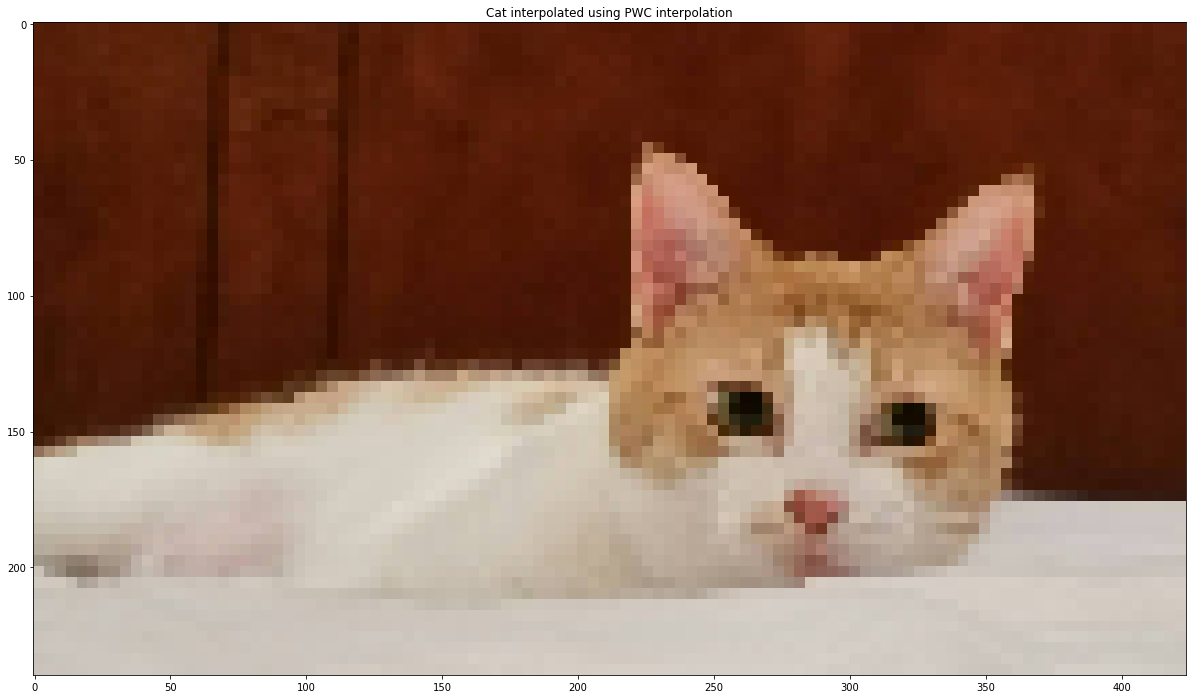

In [9]:
cat_pwc_double = np.zeros(cat400.shape,dtype=cat400.dtype)
for m in range(0,240):
    for n in range(0,424):
        for k in range(0,K):
            cat_pwc_double[m,n,k]=cat100[int(m/4),int(n/4),k]
cat_pwc = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_pwc_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_pwc)
plt.title('Cat interpolated using PWC interpolation')

# Piece-wise linear (bilinear) interpolation

If piece-wise constant (PWC) interpolation is much better than upsampling, then piece-wise linear (PWL) interpolation should be much better.

PWL interpolation in two dimensions is called ``bilinear'' interpolation.  In this case the word ``bilinear'' just means linear
in two different directions.  

A sample $z[m,n]$ in the output is closest to four different samples of the input: $$y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right)\right],$$
$$y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right)\right],$$ $$y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right)+1\right],$$ and $$y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right)+1\right].$$  The first thing to do is to calculate the fractional contribution of each of these four samples to the 
output:
$$e = \frac{m}{D} - \mbox{int}\left(\frac{m}{D}\right)$$
$$f = \frac{n}{D} - \mbox{int}\left(\frac{n}{D}\right)$$

Then we can create the output sample as

$$z[m,n,k] = \left(1-e\right)\left(1-f\right)\times y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right),k\right]$$
$$+ e\left(1-f\right)\times y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right),k\right]$$
$$+ \left(1-e\right)f \times y\left[\mbox{int}\left(\frac{m}{D}\right),\mbox{int}\left(\frac{n}{D}\right)+1,k\right]$$
$$+ ef\times y\left[\mbox{int}\left(\frac{m}{D}\right)+1,\mbox{int}\left(\frac{n}{D}\right)+1,k\right]$$


Text(0.5, 1.0, 'Cat upsampled using piece-wise linear interpolation')

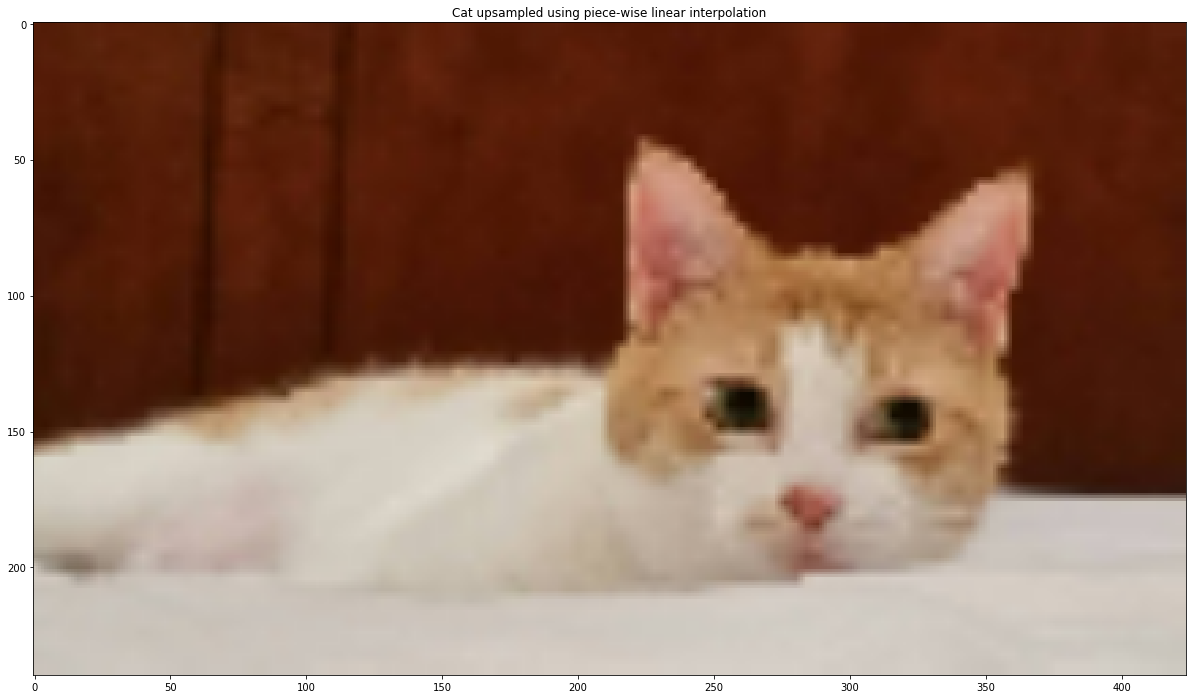

In [10]:
cat_pwl_double = np.zeros(cat400.shape,dtype='double')
for m in range(0,240):
    for n in range(0,424):
        for k in range(0,K):
            m1 = int(m/4)
            n1 = int(n/4)
            m2 = min(int(M/4-1),m1+1)
            n2 = min(int(N/4-1),n1+1)
            e = 0.25*m - m1
            f = 0.25*n - n1
            cat_pwl_double[m,n,k]=(1-e)*(1-f)*cat100[m1,n1,k]+e*(1-f)*cat100[m2,n1,k]+(1-e)*f*cat100[m1,n2,k]+e*f*cat100[m2,n2,k]

cat_pwl = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_pwl_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_pwl)
plt.title('Cat upsampled using piece-wise linear interpolation')

Notice that piece-wise-linear interpolation is just like upsampling the cat, and then convolving with the piece-wise linear interpolation filter:

$$h_{PWL}[n] = \left\{\begin{array}{ll}
\frac{D-|n|}{D} & -D\le n\le D\\
0 & \mbox{otherwise}\end{array}\right.
$$

Similarly, piece-wise constant interpolation is just like upsampling the cat, and then convolving with the piece-wise constant interpolation filter:

$$h_{PWC}[n] = \left\{\begin{array}{ll} 1 & 0\le n<D\\
0 & \mbox{otherwise}\end{array}\right.$$

Text(0.5, 1.0, 'PWL Interpolation is like convolving with the PWL interpolator')

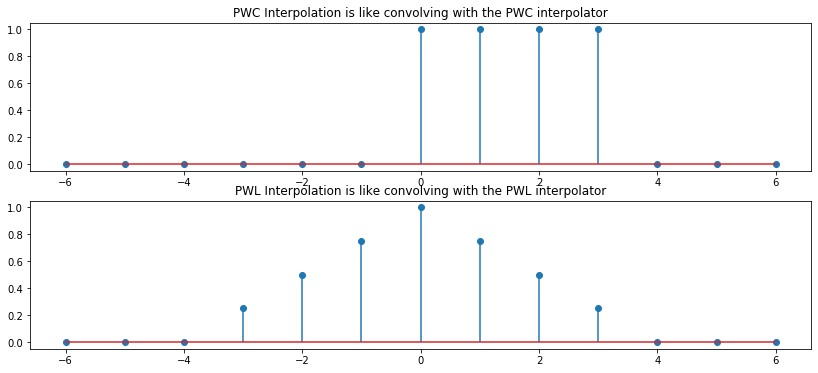

In [12]:
zero_sample = 6
n_axis = np.linspace(-zero_sample,zero_sample, 2*zero_sample+1, dtype='int16')
h_pwc = np.zeros(13)
h_pwl = np.zeros(13)
for n in range(0,4):
    h_pwc[zero_sample+n]=1
    h_pwl[zero_sample+n]=0.25*(4-n)
    h_pwl[zero_sample-n]=0.25*(4-n)
plt.figure(1,figsize=(14,6))
plt.subplot(211)
plt.stem(n_axis,h_pwc,use_line_collection=True)
plt.title('PWC Interpolation is like convolving with the PWC interpolator')
plt.subplot(212)
plt.stem(n_axis,h_pwl,use_line_collection=True)
plt.title('PWL Interpolation is like convolving with the PWL interpolator')

# Sinc Interpolation

PWC interpolation suffers from obvious blocky artifacts.  PWL interpolation smooths away most of those, but not all.
We can get rid of all of them, and get the lowpass-filtered cat back again exactly, by filtering the upsampled cat
using an ideal sinc function.

$$z[n]=D^2  h_{LPF}[n]\ast y[n]$$

Multiplying by a factor of $D^2$ is necessary because we're trying to construct $D^2$ output samples from every one input sample. 

Text(0.5, 1.0, 'Cat upsampled using sinc interpolation')

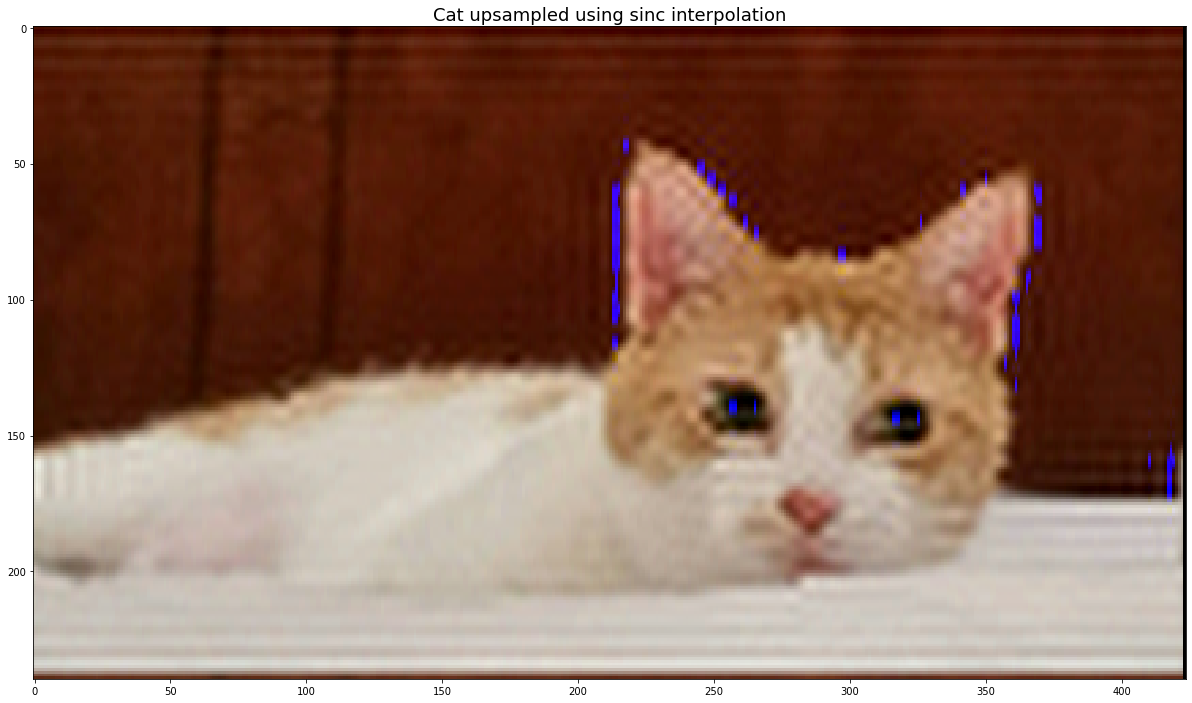

In [13]:
import scipy.ndimage.filters as filters
cat_si_double=np.zeros((240,424,3),dtype='double')
cat_half_filtered_double=np.zeros((240,424,3),dtype='double')
for k in range(0,K):
    for m in range(0,M):
        cat_half_filtered_double[m,:,k]=4*filters.convolve1d(cat_upsampled_double[m,:,k],lpf,mode='wrap')
    for n in range(0,423):
        cat_si_double[:,n,k]=4*filters.convolve1d(cat_half_filtered_double[:,n,k],lpf,mode='wrap')
cat_si = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_si_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_si)
plt.title('Cat upsampled using sinc interpolation',fontsize=18)

Text(0.5, 1.0, 'Cat upsampled using sinc-squared interpolation')

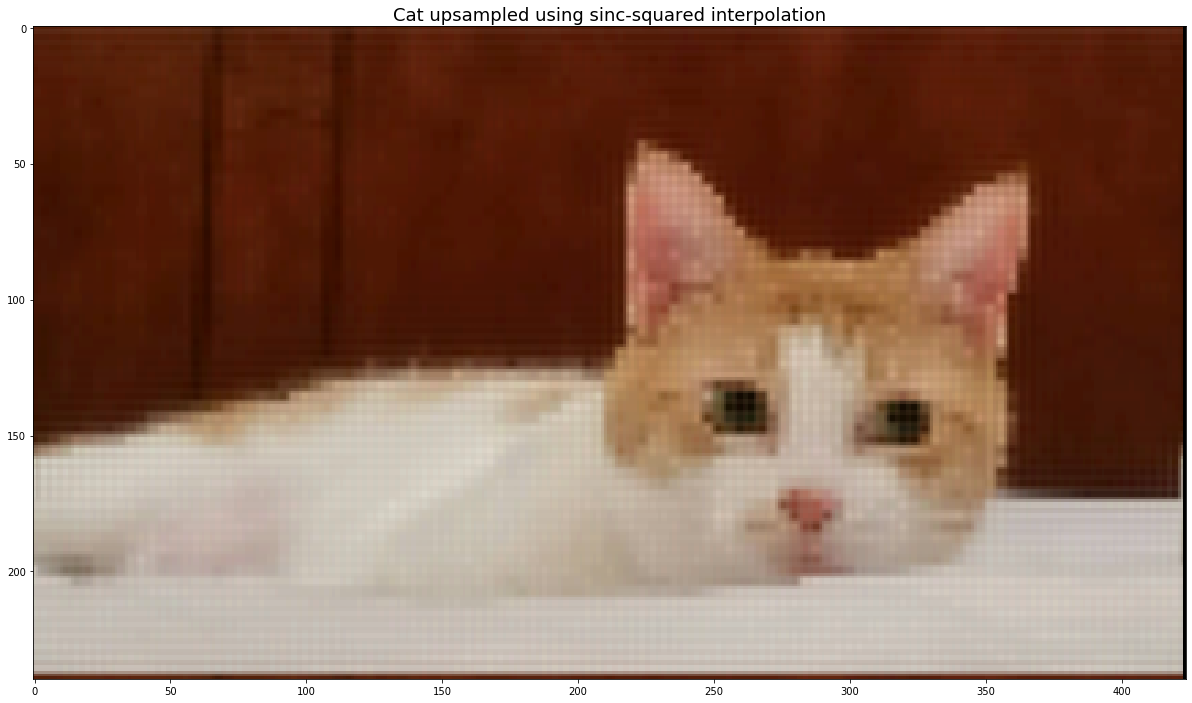

In [14]:
import scipy.ndimage.filters as filters
cat_si_double=np.zeros((240,424,3),dtype='double')
cat_half_filtered_double=np.zeros((240,424,3),dtype='double')
lpf_squared = np.zeros(lpf.shape)
for n in range(0,len(lpf)):
    lpf_squared[n] = lpf_rect[n]*lpf_rect[n]*4
for k in range(0,K):
    for m in range(0,M):
        cat_half_filtered_double[m,:,k]=4*filters.convolve1d(cat_upsampled_double[m,:,k],lpf_squared,mode='wrap')
    for n in range(0,423):
        cat_si_double[:,n,k]=4*filters.convolve1d(cat_half_filtered_double[:,n,k],lpf_squared,mode='wrap')
cat_si = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_si_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_si)
plt.title('Cat upsampled using sinc-squared interpolation',fontsize=18)

## Interpolation designed for 1/f spectra
If the image spectrum is 1/f, the sample problem in today's lecture suggests that a sinc^2 should work better than a sinc.  But it also suggests that the following spectrum might work better than a sinc^2:
$$H(\omega) = \left\{\begin{array}{ll} D&|\omega|<\frac{\pi}{D}\\
D\left(\frac{2\pi-D|\omega|}{\pi}\right)^2 & \frac{\pi}{D}<|\omega|<\frac{2\pi}{D}
\end{array}\right.$$
We can construct a filter like that as $H(\omega)=F(\omega)\ast G(\omega)\ast G(\omega)$, where $G(\omega)$ is an ideal LPF with a cutoff of $3\pi/2D$ and a height of $1$, and $F(\omega)$ is an ideal LPF with a cutoff of $\pi/4D$ and a height of $4D$.  To construct such a filter, we want
$$h[n]=f[n]g^2[n]$$
$$f[n]=\frac{3}{2D}\mbox{sinc}\left(3\pi n/2D\right)$$
$$g[n]=\mbox{sinc}\left(\pi n/4D\right)$$
Let's construct such an interpolator, and see how well it works.

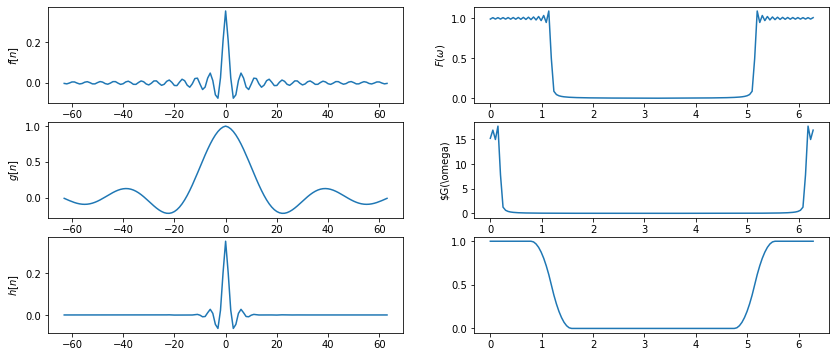

In [15]:
f_of_n = np.zeros(lpf.shape)
g_of_n = np.zeros(lpf.shape)
h_of_n = np.zeros(lpf.shape)
n_axis = np.linspace(-63.5,63.5,128,dtype='int16')
zero_sample = 63.5
omega_axis = np.linspace(0,2*math.pi,128)  
for n in range(0,64):
    f_of_n[int(zero_sample+n+0.5)] = (3/8)*np.sinc((3/8)*(n+0.5))
    g_of_n[int(zero_sample+n+0.5)] = np.sinc((1/16)*(n+0.5))
for n in range(0,64):
    f_of_n[n]=f_of_n[127-n]
    g_of_n[n]=g_of_n[127-n]
for n in range(0,128):
    h_of_n[n] = f_of_n[n]*g_of_n[n]*g_of_n[n]
plt.figure(1,figsize=(14,6))
plt.subplot(321)
plt.plot(n_axis,f_of_n)
plt.ylabel('$f[n]$')
plt.subplot(322)
plt.plot(omega_axis,abs(fft.fftn(f_of_n)))
plt.ylabel('$F(\omega)$')
plt.subplot(323)
plt.plot(n_axis,g_of_n)
plt.ylabel('$g[n]$')
plt.subplot(324)
plt.plot(omega_axis,abs(fft.fftn(g_of_n)))
plt.ylabel('$G(\omega)')
plt.subplot(325)
plt.plot(n_axis,h_of_n)
plt.ylabel('$h[n]$')
plt.subplot(326)
plt.plot(omega_axis,abs(fft.fftn(h_of_n)))

Text(0.5, 1.0, 'Cat upsampled using sinc-squared interpolation')

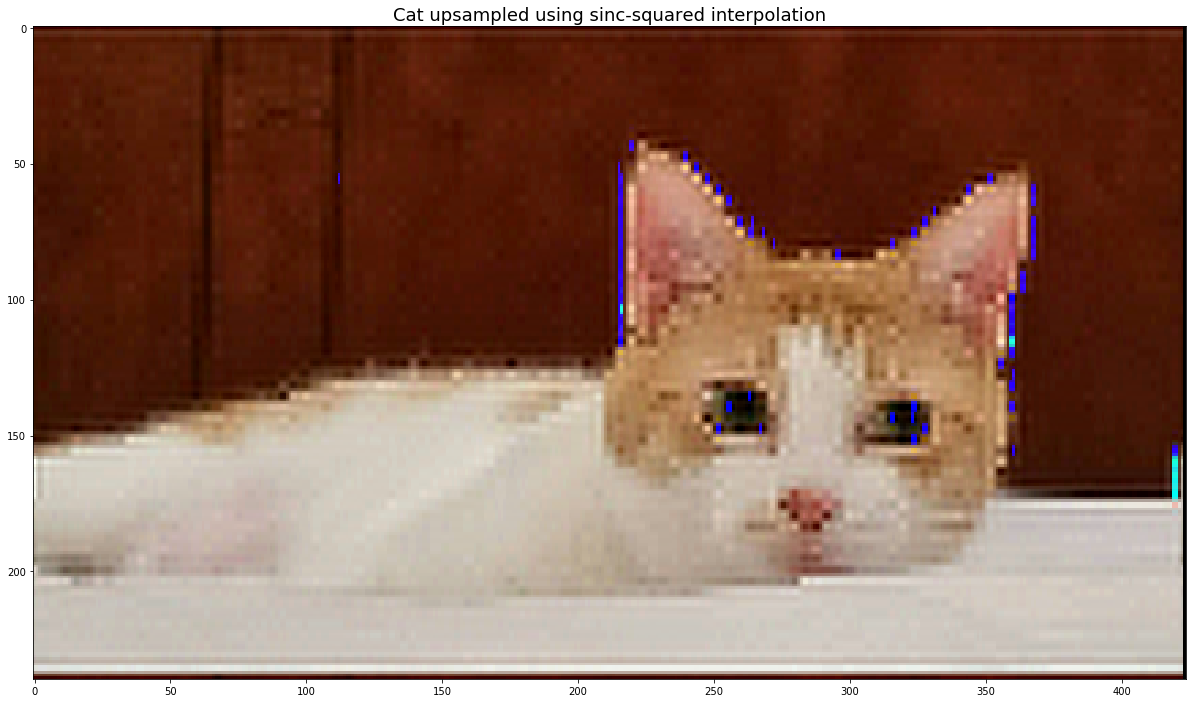

In [16]:
import scipy.ndimage.filters as filters
cat_si_double=np.zeros((240,424,3),dtype='double')
cat_half_filtered_double=np.zeros((240,424,3),dtype='double')
for k in range(0,K):
    for m in range(0,M):
        cat_half_filtered_double[m,:,k]=4*filters.convolve1d(cat_upsampled_double[m,:,k],h_of_n,mode='wrap')
    for n in range(0,423):
        cat_si_double[:,n,k]=4*filters.convolve1d(cat_half_filtered_double[:,n,k],h_of_n,mode='wrap')
cat_si = np.ndarray.astype(np.maximum(0,np.minimum(255,cat_si_double)),dtype='uint8')
plt.figure(1,figsize=(int(424*0.05),int(240*0.05)))
plt.imshow(cat_si)
plt.title('Cat upsampled using sinc-squared interpolation',fontsize=18)

# Summary of Visible Artifacts
* PWC: blocky artifacts
* PWL (Bilinear): some blocky artifacts because it interpolates within blocks, but the artifacts are a lot less than PWC interpolation.  Often, this is the best option.
* Sinc: ringing artifacts, that occur at sharp boundaries between two color, and at the edge of the image, depending on how you handle edges.
* Sinc-squared interpolation: no ringing artifact, but instead it has a kind of grid artifact.
* f-times-g-squared interpolation: has ringing artifact like sinc, but maybe it's a little less blurry than sinc.

Well, TBH I like the PWL interpolation best.  Sinc-squared would be a good option, if we could get rid of the grid artifact.

